In [24]:
%load_ext autoreload
%autoreload 2
from expressiveness_benchmark.types import Plan, Task, Language, SourceRange, Program
import pandas as pd
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
programs = Program.load_all()
tasks = Task.load_all()

<AxesSubplot:xlabel='language'>

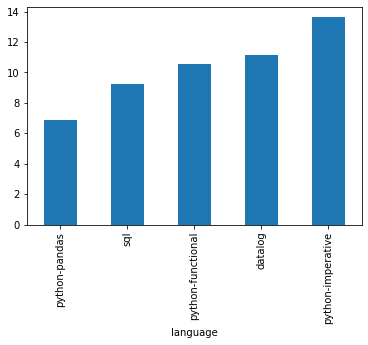

In [26]:
programs['nlines'] = programs.source.map(lambda s: len(s.split('\n')))
programs.groupby('language').mean().nlines.sort_values().plot.bar()

<AxesSubplot:xlabel='language'>

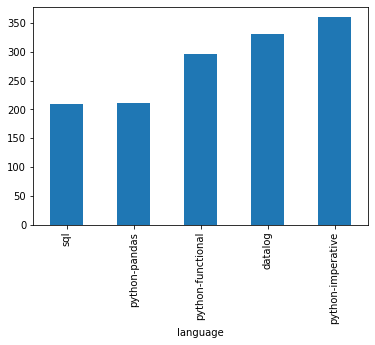

In [27]:
programs['nchars'] = programs.source.map(len)
programs.groupby('language').mean().nchars.sort_values().plot.bar()